# Imports

In [52]:
!nvidia-smi

Sun Aug  2 16:48:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |  15365MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [53]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential
import tensorflow_hub as hub

import re
import tokenization
import string
import os



from nltk.stem import PorterStemmer
st = PorterStemmer()

from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

"""
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Flatten
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
"""
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 8

SEED = 42

# Cargar data

In [55]:
data = pd.read_csv('../input/nlpdatasets/clean_train.csv')
to_predict = pd.read_csv('../input/nlpdatasets/clean_test.csv')

In [56]:
data['tweet'] = data.clean_text_no_tags.apply(lambda x: x.lower())
to_predict['tweet'] = to_predict.clean_text_no_tags.apply(lambda x: x.lower())

In [57]:
data.target.value_counts()/len(data.target)

0    0.57034
1    0.42966
Name: target, dtype: float64

# Agrupando por keywords

Tal como se dice aca https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert parece que la data se agrupa por keywords de forma bastante pareja.

Se va a aprovechar esto para hacer cross validation, pero a diferencia de lo que se propone en ese notebook, se va a ponderar por F1 score el promedio de las predicciones que se obtengan de ese cross validation.

In [58]:
print(f"keywords: {len(' '.join(data.keyword).split())}")
print(f"keywords unicas: {len(set(' '.join(data.keyword).split()))}")

keywords: 7552
keywords unicas: 221


In [59]:
data.keyword.apply(lambda x: len(x.split())).value_counts()

1    7552
0      61
Name: keyword, dtype: int64

Hay 7552 tweets con una sola keyword y 61 sin ninguna. Esto es conveniente porque entonces podemos usar un groupby para agrupar los tipos de tweets por keyword

In [60]:
tweet_types = data.groupby('keyword').target.count()
tweet_types

keyword
                       61
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: target, Length: 222, dtype: int64

In [61]:
tweet_types.describe()

count    222.000000
mean      34.292793
std        5.103441
min        9.000000
25%       33.000000
50%       35.000000
75%       37.000000
max       61.000000
Name: target, dtype: float64

Cada clase de tweets esta bastante balanceada

In [62]:
tweet_types_1 = data[data.target == 1].groupby('keyword').target.count()
tweet_types_0 = data[data.target == 0].groupby('keyword').target.count()

In [63]:
tweet_types_1.describe()

count    221.000000
mean      14.800905
std        9.820026
min        1.000000
25%        6.000000
50%       13.000000
75%       23.000000
max       42.000000
Name: target, dtype: float64

In [64]:
tweet_types_0.describe()

count    219.000000
mean      19.826484
std        9.465875
min        1.000000
25%       12.000000
50%       20.000000
75%       28.000000
max       40.000000
Name: target, dtype: float64

La distribucion de las clases dividiendolas por target tambien es bastante parecida entre ellas y en su homologo de target.

Todo esto nos habilita para seguir con esta intencion de hacer cross validation con k folds donde cada fold podria ser una agrupacion de estas clases.

La idea es que cada BERT aportaria una mirada distinta. Se estaria aplicando un Mayority Vote de BERTs.

In [65]:
keywords = set(data.groupby('keyword').id.count().index)
len(keywords)

222

In [66]:
set(to_predict.groupby('keyword').id.count().index)\
.difference(
    set(data.groupby('keyword').id.count().index))

set()

Las categorias de tweets para el set de train y test son exactamente las mismas

# Agrupando keywords por temas

Dado que vamos a hacer k fold, pero viendo que hay ciertos temas comunes entre keywords. Como no queremos mezclar temas los agrupamos. Esto generaliza bien al set de test porque comparten exactamente las mismas keywords.

Hacer esto me overfitea la distribucion. Da muy bien el train y el val pero no el pred

In [67]:
themes = [
    ['bridge%20collapse'] + ['trouble'] + ['deluge',
    'deluged'] + ['blight'] + ['battle'] + ['blaze','blazing'] + ['attack',
    'attacked'] + ['arson','arsonist'] + ['apocalypse','armageddon'] + ['catastrophe',
    'catastrophic'] + ['collapse','collapsed'] + ['collide','collided','collision',
    'crash','crashed','crush','crushed'] + ['danger','threat','hazard',
    'hazardous'] + ['demolish','demolished','demolition','rubble','ruin',
    'structural%20failure','wreck','wreckage','wrecked',
    'flattened','debris'] + ['desolate','desolation','destroy','destroyed',
    'destruction'] + ['disaster','tragedy','devastated','devastation','razed'] + ['drown','drowned',
    'drowning','electrocute','electrocuted','emergency','emergency%20plan','emergency%20services','first%20responders',
    'chemical%20emergency','engulfed','evacuate','evacuation',
    'ambulance'] + ['accident','aftershock','airplane%20accident'] + ['blew%20up','blown%20up'] + ['body%20bag',
    'body%20bagging','body%20bags'] + ['explode','explosion','exploded','loud%20bang'] + ['famine'] + ['eyewitness'] + ['fear'] + ['harm'] + ['curfew'] + ['damage'] + ['oil%20spill'] + ['displaced'] + ['drought'] + ['fatal','fatality','fatalities','casualty','dead','death',
     'deaths','casualties'] + ['injured','injury','wounds','wounded','bleeding','blood',
    'bloody','injuries'] + ['nuclear%20disaster','radiation%20emergency',
    'nuclear%20reactor'] + ['obliterate','obliteration','annihilated','annihilation',
     'obliterated'] + ['outbreak','quarantine','quarantined'],
    ['bomb','bombed','bombing','suicide%20bomb',
    'suicide%20bomber','suicide%20bombing','terrorism',
    'terrorist','detonate','detonation'] + ['bioterror','bioterrorism'] + ['hijack','hijacker','hijacking',
     'hostages','hostage'] + ['mass%20murder','mass%20murderer',
     'massacre','mayhem'] + ['military','war%20zone','army','weapon',
    'weapons'] + ['pandemonium','panic','panicking','screams','screaming','screamed'] + ['police','riot','rioting',
     'siren','sirens'] + ['refugees','rescue','rescued','rescuers','survive',
    'survived','survivors','trapped','evacuated'] + ['sinkhole','sinking','sunk'] +  ['stretcher','trauma','traumatised','upheaval',' '],
    ['storm','tornado','thunder','hurricane','thunderstorm',
    'tsunami','twister','typhoon','volcano','violent%20storm',
    'whirlwind','wild%20fires','wildfire','windstorm','rainstorm',
    'blizzard','sandstorm','snowstorm','natural%20disaster',
    'inundated','inundation','landslide','forest%20fire',
    'forest%20fires','hail','hailstorm','hellfire','cyclone',
    'lava','lightning','heat%20wave','meltdown','mudslide',
    'flood','flooding','dust%20storm','earthquake','cliff%20fall',
    'epicentre','seismic','derail','derailed','derailment',
    'avalanche','floods'] + ['fire','fire%20truck','flames','smoke','ablaze','burned',
    'burning','buildings%20burning','buildings%20on%20fire',
    'burning%20buildings','bush%20fires'],
]

# Creando Kfolds

In [136]:
def evenly_split(df):
    
    tag_1 = df[df.target == 1]
    tag_0 = df[df.target == 0]
    
    #Esto es para que el set de train y val este equilibrado entre 1 y 0 y para que el 
    #set de validacion tenga solo datos nuevos que no se usaron en train 

    tag_1_val_size = 0.25  
    tag_0_val_size = 1 - (len(tag_1) * (1 - tag_1_val_size))/(len(tag_0))

    tag_1_train, tag_1_val = train_test_split(tag_1, test_size = tag_1_val_size)
    tag_0_train, tag_0_val = train_test_split(tag_0, test_size = tag_0_val_size)

    if len(tag_0_val) > len(tag_1_val):
        tag_0_val = tag_0_val.sample(len(tag_1_val))
    else:
        tag_1_val = tag_1_val.sample(len(tag_0_val))

    train = pd.concat([tag_1_train,tag_0_train])
    val = pd.concat([tag_1_val,tag_0_val])
    
    return train, val

In [137]:
K = len(themes)

#tweet_types = tweet_types.sample(frac=1,random_state=SEED) #shuffle
#folds_names = np.array_split(tweet_types.index, K)

train_folds = []
val_folds = []
#for fold_names in folds_names:
for fold_names in themes:
    
    theme_names = pd.DataFrame(fold_names)
    theme_names.columns = ['keyword']
    
    fold = data.merge(
        theme_names, on='keyword'
    )
    train_fold, val_fold = evenly_split(fold)
    train_folds.append(train_fold)
    val_folds.append(val_fold)

# Encodeo de tweets para la red neuronal

In [70]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [71]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

porcentaje de tweets que quedan cortados: 0.03% con MAX_LEN = 160
porcentaje de palabras que se pierden al truncar: 0.43% con MAX_LEN = 160


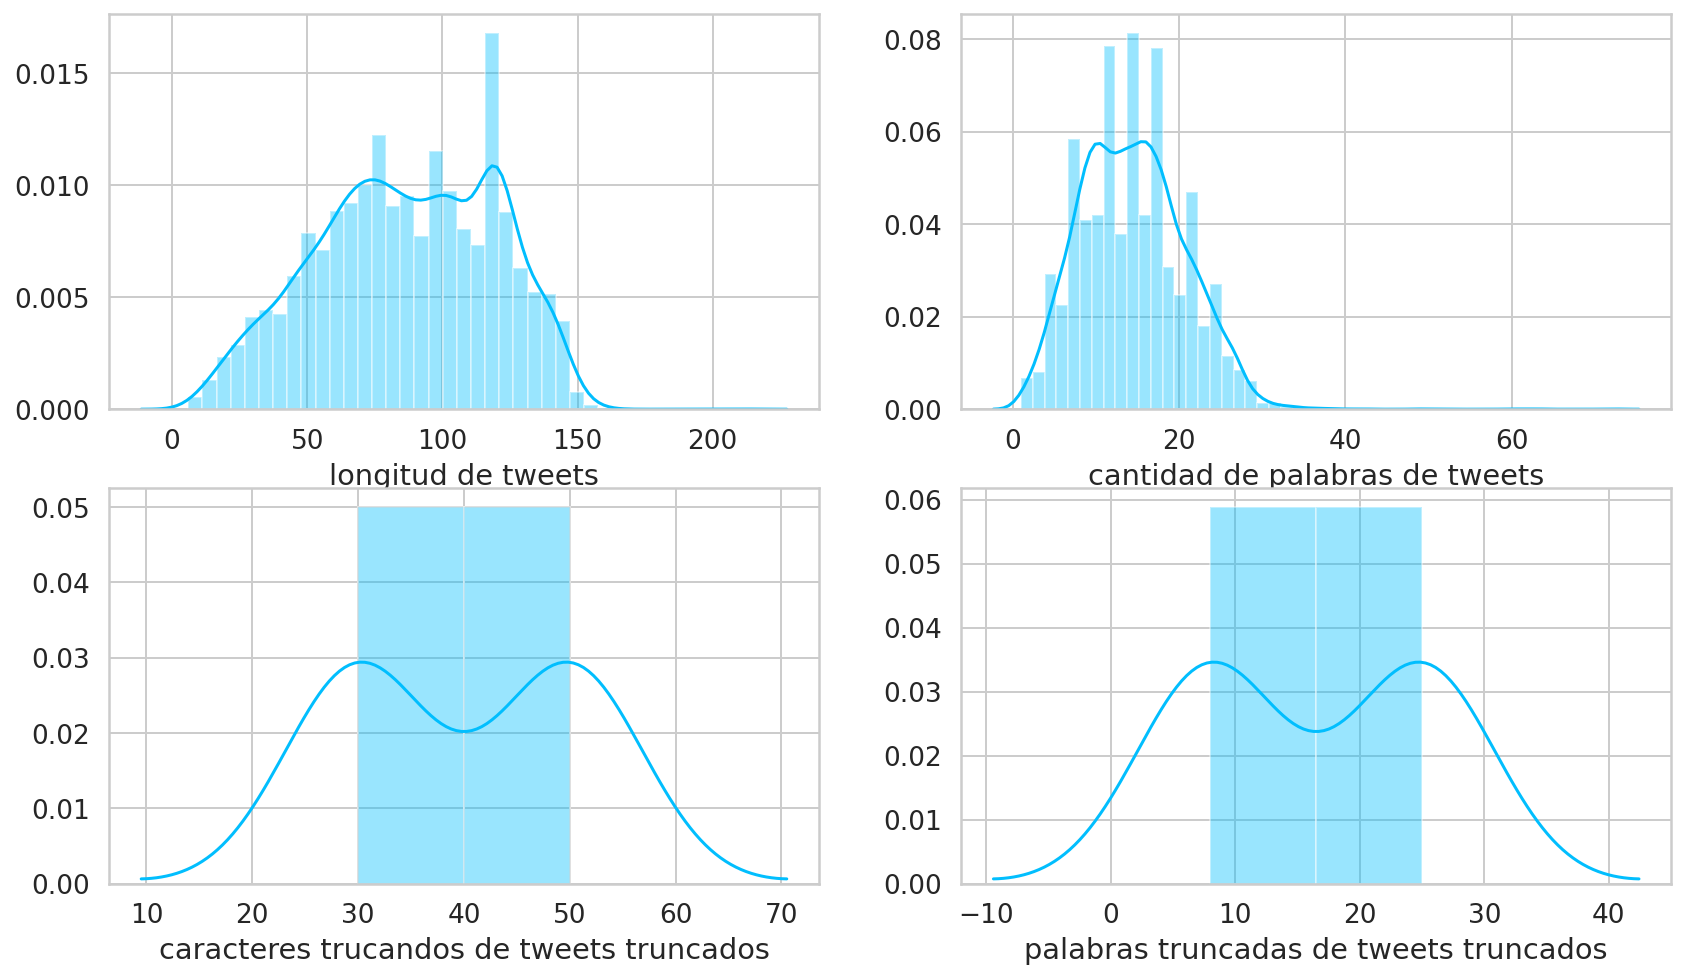

In [138]:
# La red requiere una longitud maxima y mas rapido entrena 
#cuando mas corta es la longitud por lo que estoy buscando con que longitud 
#maxima quedarme sin tirar demasiados tweets

fig, axs = plt.subplots(ncols=2,nrows=2)
MAX_LEN = 160


lens = data.tweet.apply(lambda x: len(x))
sns.distplot(lens,ax=axs[0,0])
axs[0,0].set_xlabel('longitud de tweets')
print("porcentaje de tweets que quedan cortados: {}% con MAX_LEN = {}"\
      .format(round(len(lens[ lens > MAX_LEN ])/len(data) * 100,2),MAX_LEN))


wlens = data.tweet.apply(lambda x: len(x.split()))
sns.distplot(wlens,ax=axs[0,1])
axs[0,1].set_xlabel('cantidad de palabras de tweets')


truncated_lens = lens[lens >= MAX_LEN].apply(lambda x: x - MAX_LEN)
sns.distplot(truncated_lens,ax=axs[1,0])
axs[1,0].set_xlabel('caracteres trucandos de tweets truncados')


truncated_wlens = data.tweet.apply(lambda x: len(x.split()) - len(x[:MAX_LEN].split()))
truncated_wlens = truncated_wlens[truncated_wlens > 0]
sns.distplot(truncated_wlens,ax=axs[1,1])
axs[1,1].set_xlabel('palabras truncadas de tweets truncados')
print("porcentaje de palabras que se pierden al truncar: {}% con MAX_LEN = {}"\
      .format(round(truncated_wlens.sum()/len(wlens) * 100,2),MAX_LEN))

In [164]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

#train = pd.concat(train_folds)
#val = pd.concat(val_folds)
#train, val = evenly_split(data)
train, val = train_test_split(data, test_size = 0.25, random_state = SEED, shuffle = True)

encoded_data = bert_encode(data.tweet.values, tokenizer, max_len=MAX_LEN)
encoded_train = bert_encode(train.tweet.values, tokenizer, max_len=MAX_LEN)
encoded_val = bert_encode(val.tweet.values, tokenizer, max_len=MAX_LEN)

y_data = data.target.values
total_y_train = train.target.values
total_y_val = val.target.values
x_to_predict = bert_encode(to_predict.tweet.values, tokenizer, max_len=MAX_LEN)

In [165]:
train.shape,val.shape

((5709, 11), (1904, 11))

In [166]:
train.target.value_counts()

0    3249
1    2460
Name: target, dtype: int64

In [167]:
val.target.value_counts()

0    1093
1     811
Name: target, dtype: int64

# Creacion de modelo

In [74]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Entrenando modelo

In [75]:
TRIAL = 8

best_models = []
best_scores = []

EPOCHS = 1
BATCH_SIZE = 2

for fold_num in range(K):
    
    print()
    print(f"FOLD {fold_num+1}")
    
    train_fold = train_folds[fold_num]
    val_fold = val_folds[fold_num]

    encoded_train_fold = bert_encode(train_fold.tweet.values, tokenizer, max_len=MAX_LEN)
    encoded_val_fold = bert_encode(val_fold.tweet.values, tokenizer, max_len=MAX_LEN)
    
    y_train = train_fold.target.values
    y_val = val_fold.target.values
    """
    checkpoint = ModelCheckpoint(filepath=str(TRIAL)+'_'+str(fold_num)+'.h5',
                                 monitor='val_loss', save_best_only=True, verbose = 1)"""
    model = build_model(bert_layer, max_len=MAX_LEN)
    """
    history = model.fit(encoded_train_fold,y_train, epochs=EPOCHS, 
                        validation_data=(encoded_val_fold,y_val),
                        callbacks=[checkpoint],batch_size=BATCH_SIZE)"""
    history = model.fit(encoded_train_fold,y_train, epochs=EPOCHS, 
                        validation_data=(encoded_val_fold,y_val),
                        batch_size=BATCH_SIZE)
    
    #print("TRAINING WITH WHOLE TRAIN ONCE")
    """
    model.fit(encoded_train,total_y_train, epochs=1, 
              validation_data=(encoded_val,total_y_val),
              callbacks=[checkpoint],batch_size=BATCH_SIZE)"""
    
    #model.load_weights(str(TRIAL)+'_'+str(fold_num) +'.h5')
    best_scores.append(max(history.history['val_accuracy']))
    best_models.append(model)


FOLD 1


KeyboardInterrupt: 

In [ ]:
#model1 = build_model(bert_layer, max_len=MAX_LEN)
#model1.load_weights('5_0.h5')

In [ ]:
#model = build_model(bert_layer, max_len=MAX_LEN)
model.load_weights('8_0.h5')
history = model.fit(encoded_train,total_y_train, epochs=3, 
                    validation_data=(encoded_val,total_y_val),
                    batch_size=4)

Epoch 1/3
1428/1428 [==============================] - 441s 309ms/step - loss: 0.2038 - accuracy: 0.9233 - val_loss: 0.2458 - val_accuracy: 0.9128
Epoch 2/3
 505/1428 [=========>....................] - ETA: 4:17 - loss: 0.1670 - accuracy: 0.9376

In [175]:
model.save('8_0.h5')

In [76]:
val.target.value_counts()

1    312
0    312
Name: target, dtype: int64

# Evaluacion

In [76]:
len(best_models)

1

In [78]:
mapProbs = lambda x: 1 if x>=0.5 else 0

def predict(dataset,best_models,best_scores, probs=False):
    
    total_score_sum = 0
    for score in best_scores:
        total_score_sum += score
    
    y_pred = np.zeros((dataset[0].shape[0], 1))
    for k, model in enumerate(best_models):
        score = best_scores[k]
        y_pred += model.predict(dataset) * score/total_score_sum #prediccion ponderada
        
    if probs:
        return y_pred
    
    preds = []
    for p in y_pred:
        preds.append(mapProbs(p))
        
    return preds

In [170]:
#preds = model.predict(x_val)
preds_val = predict(encoded_val,[model],[1], probs=False)

In [171]:
print(metrics.classification_report(total_y_val, preds_val,zero_division = 0))
print('F1 score: ',metrics.f1_score(total_y_val, preds_val, zero_division = 0))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1093
           1       0.90      0.89      0.89       811

    accuracy                           0.91      1904
   macro avg       0.91      0.91      0.91      1904
weighted avg       0.91      0.91      0.91      1904

F1 score:  0.8930117501546073


In [172]:
preds = predict(x_to_predict,[model],[1])

In [173]:
submit = pd.DataFrame({
    'id': list(to_predict.id),
    'target': preds
}).set_index('id')
submit

,target
id,
0,1
2,1
3,1
9,1
11,1
...,...
10861,1
10865,1
10868,1


In [95]:
submit.to_csv('BERT_keras_'+str(TRIAL)+'.csv')

In [ ]:
"""
history = model.fit(x_train,y_train, epochs=3, validation_data=(x_val,y_val),
                    callbacks=[checkpoint],batch_size=16)
TRIAL += 1


plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
"""